# Imports

In [17]:
import torch
import numpy as np
import PIL
from pathlib import Path
import pandas as pd
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

from matplotlib import colors, pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
DEVICE = torch.device("cuda")

# Defs

In [2]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


def to_kaggle(test_files, model, submit_name='base'):
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]
    submit = pd.DataFrame(test_filenames)
    submit['pred'] = preds
    submit.columns = ['Id', 'Expected']
    submit.to_csv(f'gdrive/My Drive/{submit_name}.csv', index=False)

def plot_results(history):
    loss, acc, val_loss, val_acc = zip(*history)
    sns.set(style="whitegrid", font_scale=1.4)
    fig, axs = plt.subplots(2,figsize=(15,15))
    fig.suptitle('model')
    axs[0].plot(loss, label="train_loss")
    axs[0].plot(val_loss, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set_xlabel("epochs")
    axs[0].set_ylabel("loss")
    axs[1].plot(acc, label="train_acc")
    axs[1].plot(val_acc, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set_xlabel("epochs")
    axs[1].set_ylabel("acc")
    fig.show()

    


# Data preprocessing

In [3]:
TRAIN_DIR = Path("train/simpsons_dataset")
TEST_DIR  = Path("testset/testset")

train_val_files = list(TRAIN_DIR.rglob('*.jpg'))#=> 20933
test_files = list(TEST_DIR.rglob('*.jpg'))#=> 991

In [4]:
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

n_classes = len(np.unique(train_val_labels))

# Simple CNN

In [16]:
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu111/torchvision-0.9.1%2Bcu111-cp38-cp38-win_amd64.whl (1.9 MB)
  Using cached torchaudio-0.8.1-cp38-none-win_amd64.whl (109 kB)


In [20]:
torch.cuda.is_available()

False

In [11]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, 
                batch_size=64)
plot_results(history)
to_kaggle(test_files, model=simple_cnn, submit_name='baseline')

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.4656907897579026


epoch:  50%|█████     | 1/2 [02:23<02:23, 143.99s/it]


Epoch 001 train_loss: 2.4657     val_loss 1.8256 train_acc 0.3235 val_acc 0.5099
loss 1.421224810141759


epoch: 100%|██████████| 2/2 [04:48<00:00, 144.18s/it]


Epoch 002 train_loss: 1.4212     val_loss 1.2107 train_acc 0.6125 val_acc 0.6781


# AlexNet

<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png">

In [ ]:
Alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
Alexnet.classifier = nn.Linear(num_features, n_classes)
Alexnet = Alexnet.cuda()

In [ ]:
history = train(train_dataset, val_dataset, model=Alexnet, epochs=2, 
                batch_size=64)
plot_results(history)

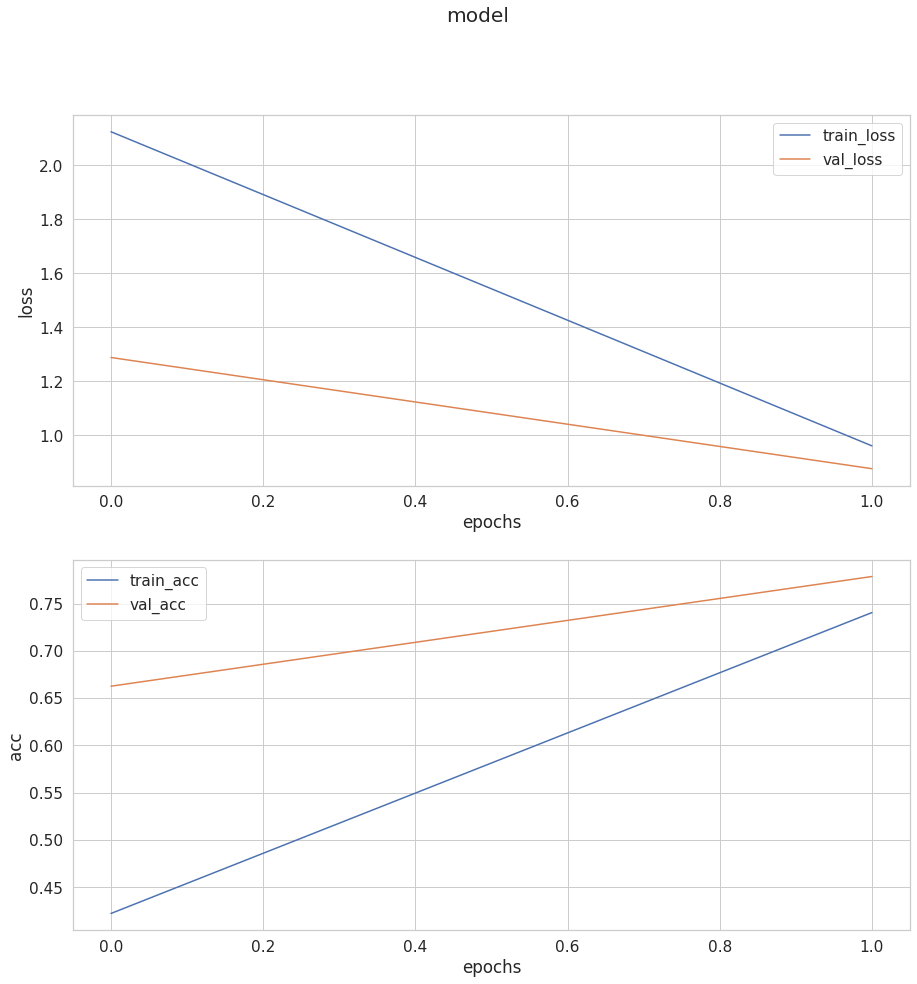

In [ ]:
plot_results(history)

In [ ]:
to_kaggle(test_files, model=simple_cnn, submit_name='AlexNet-2epoches')

# VGG-16

<img src="https://cdn-images-1.medium.com/max/1040/1*0Tk4JclhGOCR_uLe6RKvUQ.png">

In [ ]:
vgg_16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
# замораживаем параметры (веса)
for param in vgg_16.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
vgg_16.classifier = nn.Linear(num_features, n_classes)
vgg_16 = vgg_16.cuda()

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 1.7311248125160672


epoch:  11%|█         | 1/9 [03:40<29:26, 220.80s/it]


Epoch 001 train_loss: 1.7311     val_loss 1.2978 train_acc 0.6483 val_acc 0.7514
loss 0.10609750461095047


epoch:  22%|██▏       | 2/9 [07:25<25:54, 222.11s/it]


Epoch 002 train_loss: 0.1061     val_loss 1.2886 train_acc 0.9669 val_acc 0.7734
loss 0.019537534562479204


epoch:  33%|███▎      | 3/9 [11:09<22:15, 222.53s/it]


Epoch 003 train_loss: 0.0195     val_loss 1.1707 train_acc 0.9969 val_acc 0.7902
loss 0.007140578400305155


epoch:  44%|████▍     | 4/9 [14:54<18:36, 223.21s/it]


Epoch 004 train_loss: 0.0071     val_loss 1.1560 train_acc 0.9997 val_acc 0.7946
loss 0.005550876075388673


epoch:  56%|█████▌    | 5/9 [18:38<14:54, 223.52s/it]


Epoch 005 train_loss: 0.0056     val_loss 1.1460 train_acc 0.9997 val_acc 0.7988
loss 0.005343698565085566


epoch:  67%|██████▋   | 6/9 [22:23<11:11, 223.82s/it]


Epoch 006 train_loss: 0.0053     val_loss 1.1486 train_acc 0.9996 val_acc 0.8005
loss 0.002636144177522955


epoch:  78%|███████▊  | 7/9 [26:05<07:27, 223.51s/it]


Epoch 007 train_loss: 0.0026     val_loss 1.1496 train_acc 0.9999 val_acc 0.8023
loss 0.002752633129973886


epoch:  89%|████████▉ | 8/9 [29:46<03:42, 222.59s/it]


Epoch 008 train_loss: 0.0028     val_loss 1.1450 train_acc 0.9999 val_acc 0.8015
loss 0.004993918821750522


epoch: 100%|██████████| 9/9 [33:24<00:00, 222.75s/it]



Epoch 009 train_loss: 0.0050     val_loss 1.1747 train_acc 0.9999 val_acc 0.8007


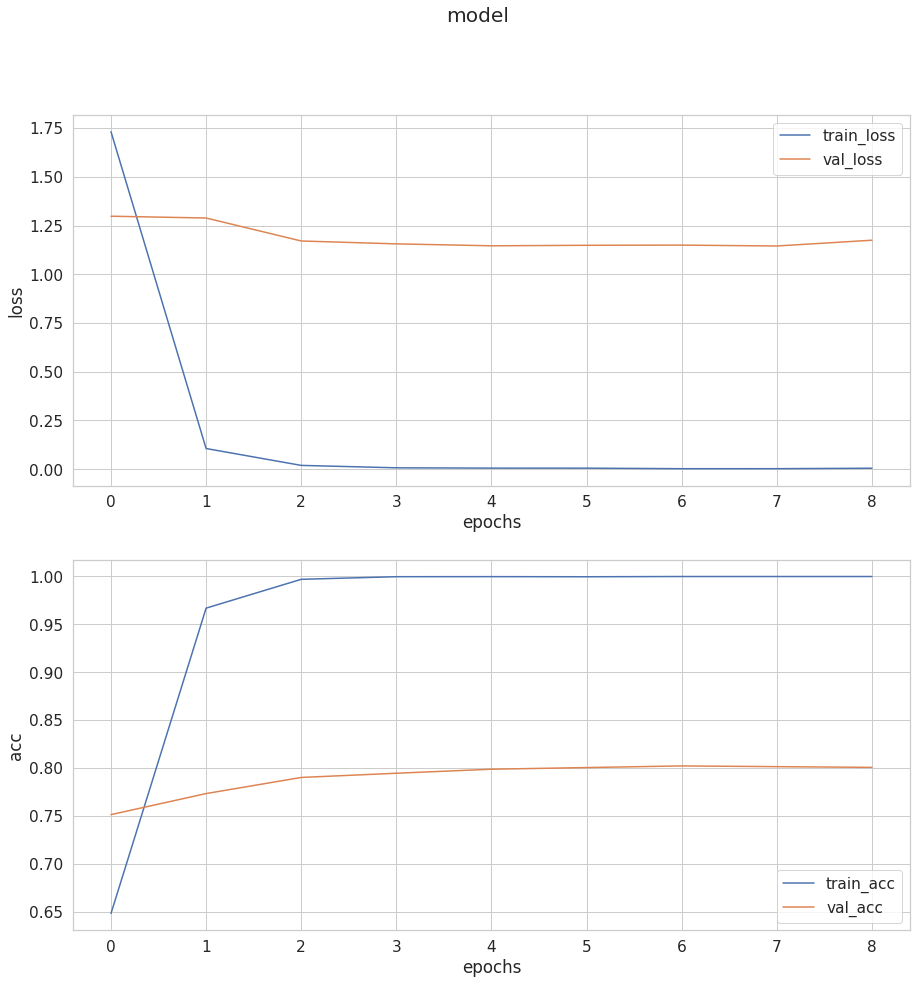

In [ ]:
history = train(train_dataset, val_dataset, model=vgg_16, epochs=9, 
                batch_size=64)
plot_results(history)

In [ ]:
to_kaggle(test_files, model=vgg_16, submit_name='vgg_16-9epoches')

# ResNet

In [ ]:
ResNet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
ResNet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# замораживаем параметры (веса)
for param in ResNet.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
ResNet.fc = nn.Linear(num_features, n_classes)
# Заменяем Fully-Connected слой на наш линейный классификатор
# ResNet.classifier = nn.Linear(num_features, n_classes)

In [ ]:
ResNet = ResNet.cuda()

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.157094071151208


epoch:   7%|▋         | 1/15 [02:35<36:13, 155.22s/it]


Epoch 001 train_loss: 2.1571     val_loss 1.5434 train_acc 0.4768 val_acc 0.6464
loss 1.2959924734309263


epoch:  13%|█▎        | 2/15 [05:07<33:25, 154.27s/it]


Epoch 002 train_loss: 1.2960     val_loss 1.2000 train_acc 0.6911 val_acc 0.6993
loss 1.0500340148805622


epoch:  20%|██        | 3/15 [07:37<30:37, 153.16s/it]


Epoch 003 train_loss: 1.0500     val_loss 1.0607 train_acc 0.7381 val_acc 0.7249
loss 0.9229895784616607


epoch:  27%|██▋       | 4/15 [10:08<27:55, 152.33s/it]


Epoch 004 train_loss: 0.9230     val_loss 1.0093 train_acc 0.7643 val_acc 0.7369
loss 0.8390029223605063


epoch:  33%|███▎      | 5/15 [12:39<25:20, 152.07s/it]


Epoch 005 train_loss: 0.8390     val_loss 0.9270 train_acc 0.7788 val_acc 0.7547
loss 0.7784514171779972


epoch:  40%|████      | 6/15 [15:10<22:46, 151.81s/it]


Epoch 006 train_loss: 0.7785     val_loss 0.9014 train_acc 0.7941 val_acc 0.7629
loss 0.7352373605017769


epoch:  47%|████▋     | 7/15 [17:42<20:12, 151.61s/it]


Epoch 007 train_loss: 0.7352     val_loss 0.8831 train_acc 0.8032 val_acc 0.7667
loss 0.7020473045424691


epoch:  53%|█████▎    | 8/15 [20:15<17:44, 152.02s/it]


Epoch 008 train_loss: 0.7020     val_loss 0.8732 train_acc 0.8109 val_acc 0.7702
loss 0.6688842097356279


epoch:  60%|██████    | 9/15 [22:46<15:11, 151.90s/it]


Epoch 009 train_loss: 0.6689     val_loss 0.8538 train_acc 0.8206 val_acc 0.7661
loss 0.640130552640196


epoch:  67%|██████▋   | 10/15 [25:20<12:42, 152.52s/it]


Epoch 010 train_loss: 0.6401     val_loss 0.8448 train_acc 0.8278 val_acc 0.7746
loss 0.6226990054204848


epoch:  73%|███████▎  | 11/15 [27:53<10:10, 152.61s/it]


Epoch 011 train_loss: 0.6227     val_loss 0.8362 train_acc 0.8300 val_acc 0.7732
loss 0.6007760979619116


epoch:  80%|████████  | 12/15 [30:26<07:38, 152.71s/it]


Epoch 012 train_loss: 0.6008     val_loss 0.8313 train_acc 0.8390 val_acc 0.7747
loss 0.588045038427621


epoch:  87%|████████▋ | 13/15 [33:00<05:06, 153.14s/it]


Epoch 013 train_loss: 0.5880     val_loss 0.8186 train_acc 0.8390 val_acc 0.7788
loss 0.5724566185202551


epoch:  93%|█████████▎| 14/15 [35:32<02:32, 152.82s/it]


Epoch 014 train_loss: 0.5725     val_loss 0.8371 train_acc 0.8436 val_acc 0.7724
loss 0.5560282410725005


epoch: 100%|██████████| 15/15 [38:04<00:00, 152.30s/it]



Epoch 015 train_loss: 0.5560     val_loss 0.8212 train_acc 0.8485 val_acc 0.7774


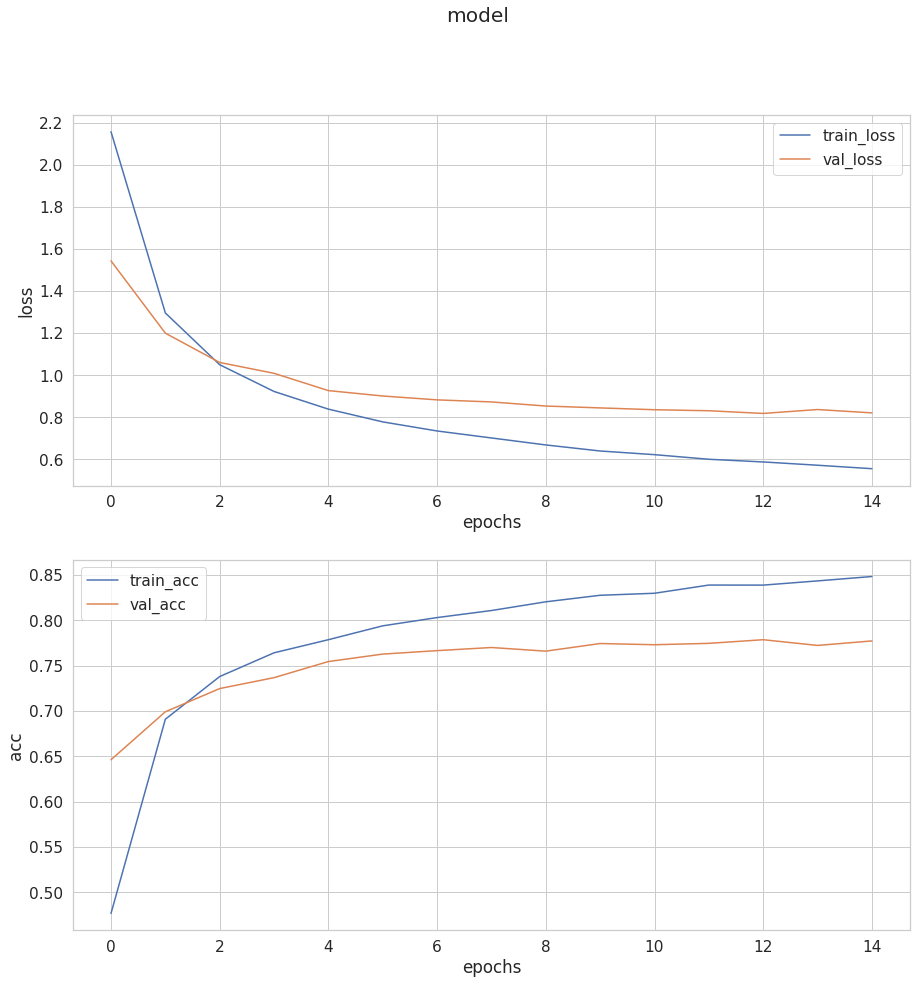

In [ ]:
history = train(train_dataset, val_dataset, model=ResNet, epochs=15, 
                batch_size=64)
plot_results(history)

In [ ]:
to_kaggle(test_files, model=ResNet, submit_name='ResNet-15epoches')